<center><img src=https://raw.githubusercontent.com/feast-dev/feast/master/docs/assets/feast_logo.png width=400/></center>

# Credit Risk Model Training

### Introduction

AI models have played a central role in modern credit risk assessment systems. In this example, we develop a credit risk model to predict whether a future loan will be good or bad, given some context data (presumably supplied from the loan application process). We use the modeling process to demonstrate how Feast can be used to facilitate the serving of data for training and inference use-cases.

In this notebook, we train our AI model. We will use the popular scikit-learn library (sklearn) to train a RandomForestClassifier, as this is a relatively easy choice for a baseline model.

### Setup

*The following code assumes that you have read the example README.md file, and that you have setup an environment where the code can be run. Please make sure you have addressed the prerequisite needs.*

In [1]:
# Imports
import warnings
import datetime
import feast
import joblib
import pandas as pd
import seaborn as sns

from feast import FeatureStore, RepoConfig
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
# Ignore warnings
warnings.filterwarnings(action="ignore")

In [3]:
# Random seed
SEED = 142

This notebook assumes that you have already done the following:

1. Run the [01_Credit_Risk_Data_Prep.ipynb](01_Credit_Risk_Data_Prep.ipynb) notebook to prepare the data.
2. Run the [02_Deploying_the_Feature_Store.ipynb](02_Deploying_the_Feature_Store.ipynb) notebook to configure the feature stores and launch the feature store servers.

If you have not completed the above steps, please go back and do so before continuing. This notebook relies on the data prepared by 1, and it uses the Feast offline server stood up by 2.

### Load Label (Outcome) Data

From our previous data exploration, remember that the label data represents whether the loan was classed as "good" (1) or "bad" (0). Let's pull the labels for training, as we will use them as our "entity dataframe" when pulling features.

This is also a good time to remember that the label timestamps are lagged by 30-90 days from the context data records.

In [4]:
labels = pd.read_parquet("Feature_Store/data/labels.parquet")

In [5]:
labels.head()

,ID,class,outcome_timestamp
0,0,good,2023-11-24 22:50:13
1,1,bad,2023-11-03 12:10:13
2,2,good,2023-11-30 22:06:03
3,3,good,2023-11-17 07:37:19
4,4,bad,2023-12-01 05:01:48


### Pull Feature Data from Feast Offline Store

In order to pull feature data from the offline store, we create a FeatureStore object that connects to the offline server (continuously running in the previous notebook).

In [6]:
# Create FeatureStore object
# (connects to the offline server deployed in 02_Deploying_the_Feature_Store.ipynb) 
store = FeatureStore(config=RepoConfig(
    project="loan_applications",
    provider="local",
    registry="Feature_Store/data/registry.db",
    offline_store={
        "type": "remote",
        "host": "localhost",
        "port": 8815
    },
    entity_key_serialization_version=2
))

Now, we can retrieve feature data by supplying our entity dataframe and feature specifications to the `get_historical_features` function. Note that this function performs a fuzzy lookback ("point-in-time") join, matching the lagged outcome timestamp to the closest application timestamp (per ID) in the context data; it also joins the "a" and "b" features that we had previously split into two tables.

To keep this example simple, we will limit our feature set to the numerical features plus two categorical features.

In [7]:
# Get feature data
# (Joins a and b data, and selects records with the right timestamps)
df = store.get_historical_features(
    entity_df=labels,
    features=[
        "data_a:duration",
        "data_a:credit_amount",
        "data_a:installment_commitment",
        "data_a:checking_status",
        "data_b:residence_since",
        "data_b:age",
        "data_b:existing_credits",
        "data_b:num_dependents",
        "data_b:housing"
    ]
).to_df()

Using outcome_timestamp as the event timestamp. To specify a column explicitly, please name it event_timestamp.


In [8]:
# Check the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   ID                      1000 non-null   int64              
 1   class                   1000 non-null   category           
 2   outcome_timestamp       1000 non-null   datetime64[ns, UTC]
 3   duration                1000 non-null   int64              
 4   credit_amount           1000 non-null   int64              
 5   installment_commitment  1000 non-null   int64              
 6   checking_status         1000 non-null   category           
 7   residence_since         1000 non-null   int64              
 8   age                     1000 non-null   int64              
 9   existing_credits        1000 non-null   int64              
 10  num_dependents          1000 non-null   int64              
 11  housing                 1000 non-null   cate

### Split the Data

Next, we split the data into a `train` and `validate` set, which we will use to train and then validate a model. The validation set will allow us to more accurately assess the model's performance on data that it has not seen during the training phase.

In [9]:
# Split data into train and validate datasets
train, validate = train_test_split(df, test_size=0.2, random_state=SEED)

### Exploratory Data Analysis

Before building a model, a data scientist needs to gain understanding of the data to make sure it meets important statistical assumptions, and to identify potential opportunities and issues. As the purpose of this particular example is to show working with Feast, we will take the view of a data scientist looking to build a quick baseline model to establish some low-end metrics.

Note that this data set is very "clean", as it has already been prepared. In real-life, production credit risk data can be much more complex, and have many issues that need to be understood and addressed before modeling.

Let's look at counts for the target variable `class`, which tells us whether a (historical) loan was good or bad. We can see that there were many more good loans than bad, making the dataset imbalanced.

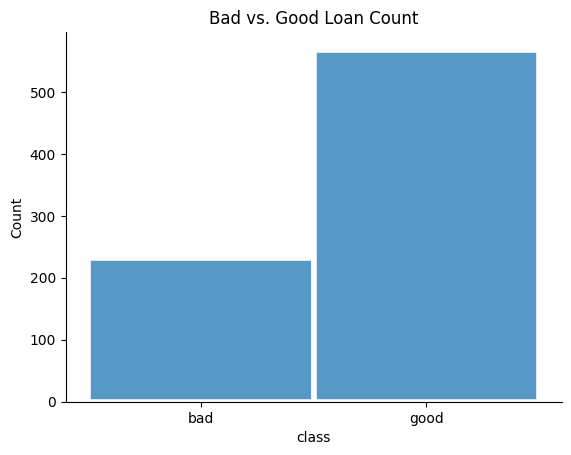

In [10]:
# plot the target variable "class"
p = sns.histplot(train["class"], ec="w", lw=4)
_ = p.set_title("Bad vs. Good Loan Count")
_ = p.spines["top"].set_visible(False)
_ = p.spines["right"].set_visible(False)

Now, view the first few records of the context data.

In [11]:
# View first records in training data
train.head()

,ID,class,outcome_timestamp,duration,credit_amount,installment_commitment,checking_status,residence_since,age,existing_credits,num_dependents,housing
18,473,good,2023-12-16 03:29:12+00:00,6,1238,4,no checking,4,36,1,2,own
764,894,good,2023-11-15 23:19:35+00:00,18,1169,4,no checking,3,29,2,1,own
504,318,good,2023-11-23 13:03:53+00:00,12,701,4,no checking,2,32,2,1,own
454,340,good,2023-12-26 17:59:37+00:00,24,5743,2,0<=X<200,4,24,2,1,for free
453,605,good,2023-12-18 11:27:02+00:00,24,2828,4,<0,4,22,1,1,own


### Feature Engineering

Once data columns have been prepared so that they can be used to train an AI model, it is common to refer to them as "features". The process of preparing features is referred to as "feature engineering". 

Below, we will train a random forest model. Random forests are relatively robust to non-standardized, non-normalized data, making it easier for us to getting started. As such, the numerical columns are ready for a simple baseline training. 

We have pulled two categorical columns, wich we will need to engineer into numerical features.

The `checking_status` column tells us roughly how much money the applicant has in their checking account, while the `housing` column shows the applicant's housing status. We presume that more money in checking correlates inversely with credit risk, while owing vs. renting, vs. living for free correlates directly with credit risk. Hence, converting these to ordinal features makes sense. Of course, in a real study we would want to quantitatively verify these presumptions.

In [12]:
# Inspect the `checking_status` column distibution
train.checking_status.value_counts(normalize=True)

checking_status
no checking    0.39375
0<=X<200       0.27500
<0             0.26125
>=200          0.07000
Name: proportion, dtype: float64

In [13]:
# Inspect the `housing` column distribution
train.housing.value_counts(normalize=True)

housing
own         0.7225
rent        0.1675
for free    0.1100
Name: proportion, dtype: float64

We define a tranformer that can be used to convert `checking_status` and `housing` to ordinal variables. The transformer will also drop the non-feature columns (`class`, `ID`, and `application_timestamp`) from the feature data.

In [14]:
# Feature lists
cat_features = ["checking_status", "housing"]
num_features = [
    "duration", "credit_amount", "installment_commitment",
    "residence_since", "age", "existing_credits", "num_dependents"
]

# Ordinal encoder for cat_features
# (We use a ColumnTransformer to passthrough numerical feature columns)
col_transform = ColumnTransformer([
        ("cat_features", OrdinalEncoder(), cat_features),
        ("num_features", "passthrough", num_features),
    ],
    remainder="drop",
)

In [15]:
# Check the tranform outputs features as expected
# (Note: transform output is an array, so we convert it
# back to dataframe for inspection)
pd.DataFrame(
    index=train.index,
    columns=cat_features + num_features,
    data= col_transform.fit_transform(train)
).head()

,checking_status,housing,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
18,3.0,1.0,6.0,1238.0,4.0,4.0,36.0,1.0,2.0
764,3.0,1.0,18.0,1169.0,4.0,3.0,29.0,2.0,1.0
504,3.0,1.0,12.0,701.0,4.0,2.0,32.0,2.0,1.0
454,0.0,0.0,24.0,5743.0,2.0,4.0,24.0,2.0,1.0
453,1.0,1.0,24.0,2828.0,4.0,4.0,22.0,1.0,1.0


Finally, let's separate out the labels, and engineer them from categorical ("good" | "bad") to float (1.0 | 0.0). We do this for both the training and validation data.

In [16]:
# Make "class" target variable numeric
train_y = (train["class"] == "good").astype(float)
validate_y = (validate["class"] == "good").astype(float)

### Train the Model

Now that the features are prepared, we can train (fit) our baseline model on the feature data.

In [17]:
# Specify the model
rf_model = RandomForestClassifier(
    n_estimators=400,
    criterion="entropy",
    max_depth=4,
    min_samples_leaf=10,
    class_weight={0:5, 1:1},
    random_state=SEED
)

# Package transform and model in pipeline
model = Pipeline([("transform", col_transform), ("rf_model", rf_model)])

In [18]:
# Fit the model
model.fit(train, train_y)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('cat_features',
                                                  OrdinalEncoder(),
                                                  ['checking_status',
                                                   'housing']),
                                                 ('num_features', 'passthrough',
                                                  ['duration', 'credit_amount',
                                                   'installment_commitment',
                                                   'residence_since', 'age',
                                                   'existing_credits',
                                                   'num_dependents'])])),
                ('rf_model',
                 RandomForestClassifier(class_weight={0: 5, 1: 1},
                                        criterion='entropy', max_depth=4,
                                        min_samples_leaf=10, n_estimators=400,
                                        random_state=142))])

### Evaluate the Model

Let's evaluate our baseline model performance. With credit risk, recall is going to be an important measure to look at. We compare the performance on the training data, with the performance on the validation data through a classification report.

In [19]:
# Evaluate training set performance
train_preds = model.predict(train)
print(classification_report(train_y, train_preds))

              precision    recall  f1-score   support

         0.0       0.42      0.92      0.58       232
         1.0       0.94      0.49      0.64       568

    accuracy                           0.61       800
   macro avg       0.68      0.70      0.61       800
weighted avg       0.79      0.61      0.63       800



In [20]:
# Evaluate validation data performance
print(classification_report(validate_y, model.predict(validate)))

              precision    recall  f1-score   support

         0.0       0.46      0.87      0.61        68
         1.0       0.88      0.48      0.62       132

    accuracy                           0.61       200
   macro avg       0.67      0.68      0.61       200
weighted avg       0.74      0.61      0.62       200



The recall on the validation set for bad loans (0 class) is 0.87, meaning that the model correctly identified close to 90% of the bad loans. However, the precision of 0.46 tells us that the model is also classifying many loans that were actually good as bad. Precision and recall are technical metrics. In order to truly assess the models value, we would need feedback from the business side on the impact of misclassifications (for both good and bad loans).

The difference in performance on the training vs. validation data, tells us that the model is slightly overfitting the data. Remember that this is just a quick baseline model. To improve further, we could do things like:
- gather more data
- engineer features
- experiment with hyperparameter settings
- experiment with other model types

In fact, this is just a start. Creating AI models that meet business needs often requires a lot of guided experimentation.

### Save the Model

The last thing we do is save our trained model, so that we can pick it up later in the serving environment.

In [21]:
# Save the model to a pickle file
joblib.dump(model, "rf_model.pkl")

['rf_model.pkl']

In the next notebook, [04_Credit_Risk_Model_Serving.ipynb](04_Credit_Risk_Model_Serving.ipynb), we will load the trained model and request predictions, with input features provided by the Feast online feature server.